<a href="https://colab.research.google.com/github/machiwao/CCDEPLRL_PROJECT_COM222/blob/main/CCDEPLRL_PROJECT_COM222_Project_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ArtDecode: An Explainable Deep Learning-Based Mobile Application for Multi-Style Artistic Image Classification and Visual Feature Interpretation

In [57]:
import numpy as np
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from PIL import Image  # PIL is used to load the image
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.regularizers import l2

## Data Loading

Mount Google Drive Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load images and respective labels

In [3]:
base_dir = '/content/drive/My Drive/Primary Data' # Adjust this path if "Primary Data" is in a different location

In [4]:
styles = os.listdir(base_dir)
print(styles) # Print the list of styles to verify

['Primitivism', 'Art_Nouveau', 'Realism', 'Neoclassicism', 'Baroque', 'Japanese_Art', 'Academic_Art', 'Renaissance', 'Rococo', 'Expressionism', 'Romanticism', 'Symbolism', 'Western Medieval']


In [6]:
images = []
labels = []
for style in styles:
    style_dir = os.path.join(base_dir, style)
    for image_name in os.listdir(style_dir):
        image_path = os.path.join(style_dir, image_name)
        try:
            img = Image.open(image_path).convert('RGB') # Load image and convert to RGB
            img = img.resize((128, 128)) # Resize images to a consistent size
            img_array = np.array(img)
            images.append(img_array)
            labels.append(style) # Use the style name as the label
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")

images = np.array(images)

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (96714256 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


## Data Split

In [33]:
# Train-Validation-Test Split is 70-10-20
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.66, random_state=42)

In [34]:
# Convert y_train to a NumPy array to use NumPy functions
y_train_np = np.array(y_train)

# Get unique values and their counts
unique_elements, counts = np.unique(y_train_np, return_counts=True)

# Print the counts
print("Counts of each style in y_train:")
for element, count in zip(unique_elements, counts):
    print(f"{element}: {count}")

Counts of each style in y_train:
Academic_Art: 704
Art_Nouveau: 697
Baroque: 697
Expressionism: 701
Japanese_Art: 688
Neoclassicism: 687
Primitivism: 707
Realism: 688
Renaissance: 703
Rococo: 682
Romanticism: 697
Symbolism: 731
Western Medieval: 718


In [35]:
# Convert y_val to a NumPy array to use NumPy functions
y_val_np = np.array(y_val)

# Get unique values and their counts
unique_elements, counts = np.unique(y_val_np, return_counts=True)

# Print the counts
print("Counts of each style in y_val:")
for element, count in zip(unique_elements, counts):
    print(f"{element}: {count}")

Counts of each style in y_val:
Academic_Art: 113
Art_Nouveau: 111
Baroque: 98
Expressionism: 102
Japanese_Art: 88
Neoclassicism: 119
Primitivism: 93
Realism: 105
Renaissance: 102
Rococo: 110
Romanticism: 115
Symbolism: 96
Western Medieval: 74


In [36]:
label_to_index = {style: i for i, style in enumerate(styles)}
y_train_encoded = to_categorical([label_to_index[label] for label in y_train], num_classes=len(styles))
y_val_encoded = to_categorical([label_to_index[label] for label in y_val], num_classes=len(styles))
y_test_encoded = to_categorical([label_to_index[label] for label in y_test], num_classes=len(styles))

# Normalize the image data after splitting
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

## Model Training

In [64]:
model = tf.keras.Sequential([
    # Block 1
    tf.keras.layers.Conv2D(64, 3, padding='same', kernel_regularizer=l2(1e-4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(64, 3, padding='same', kernel_regularizer=l2(1e-4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Dropout(0.1),

    # Block 2
    tf.keras.layers.Conv2D(128, 3, padding='same', kernel_regularizer=l2(1e-4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(128, 3, padding='same', kernel_regularizer=l2(1e-4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Dropout(0.2),

    # Block 3
    tf.keras.layers.Conv2D(256, 3, padding='same', kernel_regularizer=l2(1e-4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.GlobalAveragePooling2D(),

    # Dense layers
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=l2(1e-4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(len(styles), activation='softmax')
])

In [65]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ ?                      │   0 (unbuilt

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [66]:
# Initialize starting learning rate
optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4)
# Compile the model
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False, label_smoothing = 0.1),
    metrics=['accuracy']
)

In [67]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience = 20,
    restore_best_weights=True,
    verbose=1,
    min_delta=0.0001,
)

In [68]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,        # Reduce LR by half
    patience=10,        # Wait 3 epochs before reducing
    min_lr=1e-7,       # Don't go below this
    min_delta=0.0001,
    verbose=1
)

In [69]:
# Fit the model
history = model.fit(
    X_train, y_train_encoded, # Use the one-hot encoded training labels
    epochs=100,
    validation_data=(X_val, y_val_encoded), # Use the one-hot encoded validation labels
    callbacks=[early_stop, reduce_lr],
    batch_size=32
)

Epoch 1/100
285/285 ━━━━━━━━━━━━━━━━━━━━ 51s 129ms/step - accuracy: 0.1843 - loss: 2.7962 - val_accuracy: 0.0897 - val_loss: 2.7488 - learning_rate: 0.0010
Epoch 2/100
285/285 ━━━━━━━━━━━━━━━━━━━━ 64s 91ms/step - accuracy: 0.2486 - loss: 2.4582 - val_accuracy: 0.1327 - val_loss: 2.9468 - learning_rate: 0.0010
Epoch 3/100
285/285 ━━━━━━━━━━━━━━━━━━━━ 41s 89ms/step - accuracy: 0.2879 - loss: 2.3435 - val_accuracy: 0.1531 - val_loss: 3.8369 - learning_rate: 0.0010
Epoch 4/100
285/285 ━━━━━━━━━━━━━━━━━━━━ 41s 90ms/step - accuracy: 0.3314 - loss: 2.2476 - val_accuracy: 0.2097 - val_loss: 2.8777 - learning_rate: 0.0010
Epoch 5/100
285/285 ━━━━━━━━━━━━━━━━━━━━ 41s 91ms/step - accuracy: 0.3530 - loss: 2.1718 - val_accuracy: 0.2632 - val_loss: 2.4433 - learning_rate: 0.0010
Epoch 6/100
285/285 ━━━━━━━━━━━━━━━━━━━━ 41s 91ms/step - accuracy: 0.3838 - loss: 2.1019 - val_accuracy: 0.2873 - val_loss: 2.4903 - learning_rate: 0.0010
Epoch 7/100
285/285 ━━━━━━━━━━━━━━━━━━━━ 41s 90ms/step - accuracy: 0.

## Model Evaluation

In [70]:
def plot_history(history):
  fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 12))
  ax1.plot(history.history['accuracy'])
  ax1.plot(history.history['val_accuracy'])
  ax1.set_title('model accuracy')
  ax1.set_ylabel('accuracy')
  ax1.set_xlabel('epoch')
  ax1.legend(['train', 'validation'], loc='upper left')
  ax2.plot(history.history['loss'])
  ax2.plot(history.history['val_loss'])
  ax2.set_title('model loss')
  ax2.set_ylabel('loss')
  ax2.set_xlabel('epoch')

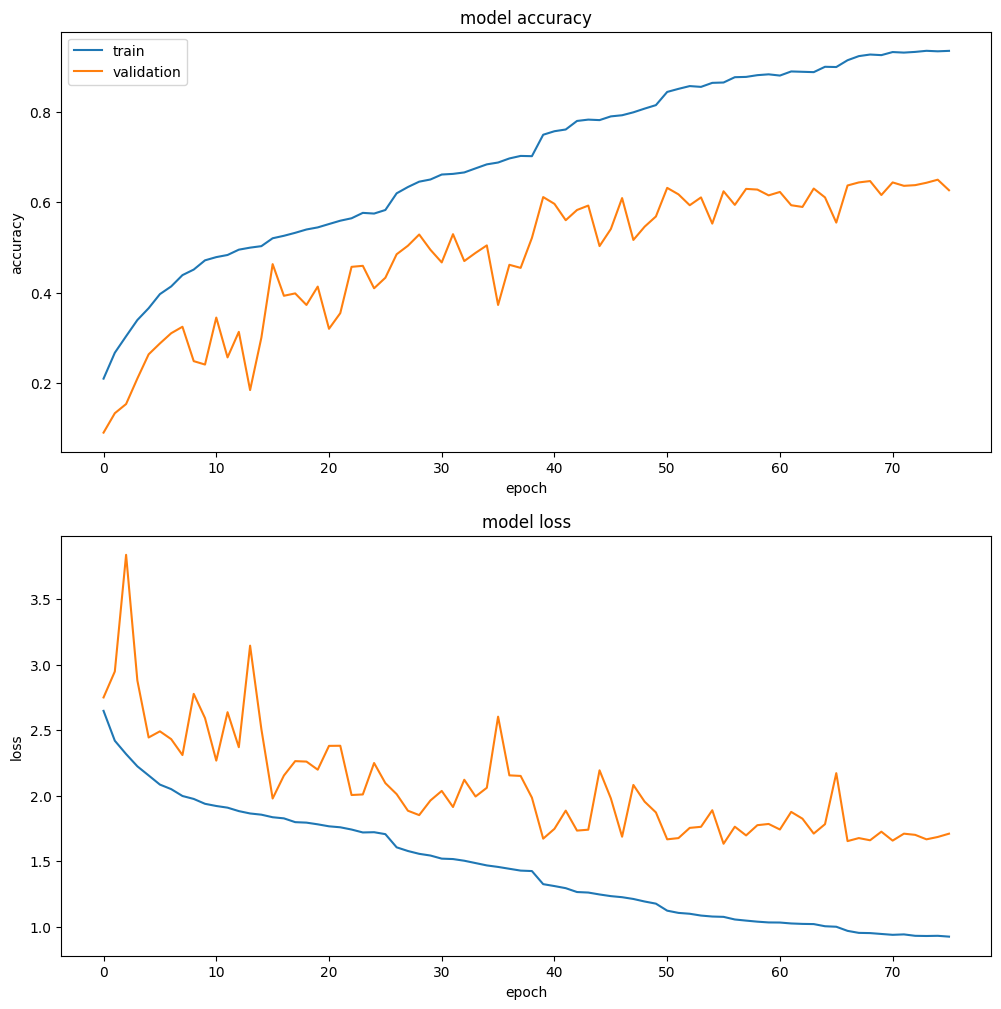

In [71]:
# Plot Loss Graphs
plot_history(history)

In [72]:
model.evaluate(X_test, y_test_encoded)

81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.6467 - loss: 1.6043


[1.6057415008544922, 0.6499611735343933]

In [73]:
# Print Classification Report. Print which number represents which art style
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
print(classification_report(y_test_classes, y_pred_classes, target_names=styles))

81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step
                  precision    recall  f1-score   support

     Primitivism       0.79      0.77      0.78       200
     Art_Nouveau       0.78      0.74      0.76       192
         Realism       0.54      0.43      0.48       207
   Neoclassicism       0.73      0.78      0.76       194
         Baroque       0.47      0.68      0.56       205
    Japanese_Art       0.82      0.82      0.82       224
    Academic_Art       0.68      0.56      0.61       183
     Renaissance       0.64      0.55      0.59       195
          Rococo       0.69      0.64      0.66       208
   Expressionism       0.81      0.57      0.67       197
     Romanticism       0.43      0.60      0.50       188
       Symbolism       0.44      0.50      0.47       173
Western Medieval       0.83      0.76      0.80       208

        accuracy                           0.65      2574
       macro avg       0.66      0.65      0.65      2574
    weighted avg       0.67   